In [1]:
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import make_scorer, mean_absolute_error, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

from sklearn.pipeline import make_union
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate

from category_encoders import OrdinalEncoder, OneHotEncoder, CountEncoder

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from pathlib import Path
import config

sys.path.append('./starspace36_mono_model')
# import starspace_resources as sw_resources

pd.set_option('display.max_rows', 120)
plt.style.use("dark_background")
plt.rcParams['figure.figsize'] = (20, 15)

print(Path.cwd())

/home/flu/flu_vaccine_challenge/drivendata_flu_shot


In [2]:
X = pd.read_csv("./input/training_set_features.csv", index_col='respondent_id')
y = pd.read_csv("./input/training_set_labels.csv", index_col='respondent_id')
submission_format = pd.read_csv("./input/submission_format.csv", index_col='respondent_id')
test_set = pd.read_csv("./input/test_set_features.csv", index_col='respondent_id')

In [3]:
print('y.head()')
y.head()


y.head()


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [4]:
#  Encoders

ordinal_label_encoder_pipe = Pipeline([

    ('label-encoder', OrdinalEncoder(cols=config.categorical)),
    # ('quasy_constant_remover', VarianceThreshold(.99 * (1 - .99))),
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('scaler', StandardScaler()),
    # ('regressor', BayesianRidge())
])

In [5]:
print("test_set")
test_set.head()


test_set


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird


In [6]:
# split for starspace and catboost datasets
X.replace(to_replace=config.ordinal_to_replace, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)

In [7]:
X_hyper_encoder = ordinal_label_encoder_pipe.fit(X=X)
X_hyper_values = X_hyper_encoder.transform(X).astype(dtype=str)
X_hyper = pd.DataFrame(data=X_hyper_values, index=X.index, columns=X.columns)

print(X_hyper.shape, X.shape)

(26707, 35) (26707, 35)


In [8]:
ordinal_encoder = ordinal_label_encoder_pipe.fit(X=X_train)
X_train = pd.DataFrame(data=ordinal_encoder.transform(X_train),
                 index=X_train.index,
                 columns=X_train.columns).astype(int, errors='ignore')
X_train = X_train.astype(dtype=str)

# X_train
# print('есть ли после трансформации OrdinalEncoder значения не int', any(X_train.dtypes != int))

In [9]:
X_test = pd.DataFrame(data=ordinal_encoder.transform(X_test),
                 index=X_test.index,
                 columns=X_test.columns).astype(int, errors='ignore')
X_test = X_test.astype(dtype=str)

# print('X_test')
# print('есть ли после трансформации OrdinalEncoder значения не int', any(X_test.dtypes != int))

In [10]:
test_set.replace(to_replace=config.ordinal_to_replace, inplace=True)
test_set = pd.DataFrame(data=ordinal_encoder.transform(test_set),
                 index=test_set.index,
                 columns=test_set.columns).astype(int, errors='ignore')

test_set = test_set.astype(str)


In [11]:
h1n1_train_counts = y.h1n1_vaccine.value_counts()
# h1n1_test_counts = y.h1n1_vaccine.value_counts()

print("соотношения классов")
print(f"h1n1_train_counts train \n {h1n1_train_counts.values} {h1n1_train_counts[1] / h1n1_train_counts[0]}")
# print("h1n1_test_counts test \n", h1n1_test_counts.values, h1n1_test_counts[1] / h1n1_test_counts[0])

соотношения классов
h1n1_train_counts train 
 [21033  5674] 0.26976655731469595


In [12]:
seasonal_train_counts = y.seasonal_vaccine.value_counts()
# h1n1_test_counts = y.h1n1_vaccine.value_counts()

print("соотношения классов")
print(f"seasonal_train_counts train \n {seasonal_train_counts.values} {seasonal_train_counts[1] / seasonal_train_counts[0]}")
# print("h1n1_test_counts test \n", h1n1_test_counts.values, h1n1_test_counts[1] / h1n1_test_counts[0])

соотношения классов
seasonal_train_counts train 
 [14272 12435] 0.8712864349775785


In [13]:
def hyperopt_ctb_scoreCV(params):
    
    global global_hyperopt_counter   # Переменная, чтобы считать и печатать номер итерации
    global X_hyper
    global y_hyper
    global global_best_model
    
    global_hyperopt_counter  += 1
    
    # if global_hyperopt_counter % 10 == 0:
    # print(f'*****  iterations  {global_hyperopt_counter}')

    for key in catboost_space:
        print(f'       {key} {params[key]}')
    
    clf = CatBoostClassifier(**params)
    
    fit_params = {
        'cat_features': X_hyper.columns,
        'use_best_model': True,
        # 'metric_period': None,
        'logging_level': 'Verbose',
        # 'silent': None,
        'early_stopping_rounds': 100,
    }
    cross_val_result = cross_validate(
        estimator=clf,
        X=X_hyper,
        y=y_hyper,
        scoring='roc_auc',
        n_jobs=4,
        fit_params=fit_params,
        cv=3,
        return_estimator=True,
        error_score='raise',
    )

    # current_score = clf.get_best_score()['validation']['AUC']
    current_score = cross_val_result['test_score'].mean()

    if current_score > global_best_model['AUC']:
        global_best_model['AUC'] = current_score
        global_best_model['model'] = cross_val_result['estimator']
        print(f'new best AUC = {current_score}')

    result = {
        'loss': -current_score,
        'status': STATUS_OK,

        # -- store other results like this
        'eval_time': time.time(),
        'other_stuff': {'type': None, 'value': [0, 1, 2]},
        # 'model': clf,
        # -- attachments are handled differently
        'attachments':
            {'attachments': 'attachments'}
    }
        
    return result

In [14]:
def hyperopt_ctb_scoreCV_manual(params):
    
    global X_hyper
    global y_hyper
    global global_best_model

    for key in catboost_space:
        print(f'       {key} {params[key]}')
    
    clf = CatBoostClassifier(**params)
    skf = StratifiedKFold(n_splits=3)
    
    cross_val_result = {'estimator': [], 'test_score': []}
    for i, (train_ind, val_ind) in enumerate(skf.split(X_hyper, y_hyper)):
        
        train_set = Pool(data=X_hyper.loc[train_ind], label=y_hyper[train_ind], cat_features=X_hyper.columns)
        val_set = Pool(data=X_hyper.loc[val_ind], label=y_hyper[val_ind], cat_features=X_hyper.columns)
        
        clf.fit(X=train_set, eval_set=val_set, use_best_model=True)
        cross_val_result['estimator'].append(clf)
        cross_val_result['test_score'].append(clf.get_best_score()['validation']['AUC'])
    

    # current_score = clf.get_best_score()['validation']['AUC']
    current_score = np.mean(cross_val_result['test_score'])

    if current_score > global_best_model['AUC']:
        global_best_model['AUC'] = current_score
        global_best_model['model'] = cross_val_result['estimator']
        print(f'new best AUC = {current_score}')

    result = {
        'loss': -current_score,
        'status': STATUS_OK,

        # -- store other results like this
        'eval_time': time.time(),
        'other_stuff': {'type': None, 'value': [0, 1, 2]},
        # 'model': clf,
        # -- attachments are handled differently
        'attachments':
            {'attachments': 'attachments'}
    }
        
    return result

In [15]:
def hyperopt_ctb_score(params):
    
    # global global_hyperopt_counter   # Переменная, чтобы считать и печатать номер итерации
    global train_set
    global val_set
    global global_best_model
    
    global_hyperopt_counter  += 1
    
    # if global_hyperopt_counter % 10 == 0:
    # print('*****  iterations ', global_hyperopt_counter)
    
    for key in catboost_space:
        print(key, params[key])
        
    clf = CatBoostClassifier(**params)
    
    try:
        clf.fit(X=train_set, eval_set=val_set, use_best_model=True)
        current_score = clf.get_best_score()['validation']['AUC']
        
        if current_score > global_best_model['AUC']:
            global_best_model['AUC'] = current_score
            global_best_model['model'] = [clf]
            
            print(f'new best AUC = {current_score}')
        
        # print('current_score', current_score)
        result = {
            'loss': -current_score,
            'status': STATUS_OK,

            # -- store other results like this
            'eval_time': time.time(),
            'other_stuff': {'type': None, 'value': [0, 1, 2]},
            # 'model': clf,
            # -- attachments are handled differently
            'attachments':
                {'attachments': 'attachments'}
        }
    except Exception as e:
        print(f"{'*'*20} Exception occured : .... \n", e)
        result = {
            'loss': 1,
            'status': STATUS_OK,
        }
        
    return result

In [16]:
catboost_space = {

    # 'grow_policy': hp.choice('grow_policy', ['Lossguide', 'Depthwise']), # 'SymmetricTree',  #  'Depthwise',
    # 'auto_class_weights': hp.choice('auto_class_weights', ['SqrtBalanced','Balanced']),
    # 'langevin': True,  # CPU only
    # 'learning_rate': hp.quniform('learning_rate', 1e-3, 3e-2, 1e-3),
    'depth':  hp.choice('depth', np.arange(5, 14, dtype=int)),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1, 300, 1),
    'max_leaves': hp.choice('max_leaves', np.arange(5, 64, dtype=int)),  
    'border_count': hp.choice('border_count', np.arange(64, 256, dtype=int)), 

    'random_strength': hp.quniform('random_strength', 1e-3, 8e-1, 1e-3), 
    'bagging_temperature': hp.quniform('bagging_temperature', 1e-3, 8e-1, 1e-3), 
}

In [17]:
%%time 

# Hyperopt main loop

# global_hyperopt_counter = 0
# hyper_best_params = {}
models = {}
best_models = {}
for col in y.columns:
    print('********* Hyperopt main loop', col, '*****************')
    
    global_best_model = {'AUC': -1, 'model': None}
    
    y_hyper = y[col]
    
#     train_set = Pool(data=X_train, label=y_train[col], cat_features=X_train.columns)
#     val_set = Pool(data=X_test, label=y_test[col], cat_features=X_test.columns)

    hyperopt_local_params = config.params.copy()
    hyperopt_local_params.update(catboost_space)

    # trials = Trials()
    # best = fmin(fn=hyperopt_ctb_score, space=hyperopt_local_params, algo=tpe.suggest, max_evals=100, trials=trials, verbose=False)
    best = fmin(fn=hyperopt_ctb_scoreCV_manual, 
                space=hyperopt_local_params, 
                algo=tpe.suggest, 
                max_evals=20, 
                verbose=True,
               )

    models[col] = global_best_model
    
#     hyperopt_local_params.update(best)
#     hyper_best_params[col] = hyperopt_local_params

********* Hyperopt main loop h1n1_vaccine *****************
       depth 12                                       
       l2_leaf_reg 159.0                              
       max_leaves 32                                  
       border_count 190                               
       random_strength 0.779                          
       bagging_temperature 0.146                      
0:	learn: 0.7870929	test: 0.7901977	best: 0.7901977 (0)	total: 91.7ms	remaining: 13m 45s

1000:	learn: 0.8657359	test: 0.8611858	best: 0.8611858 (1000)	total: 33.9s	remaining: 4m 30s

2000:	learn: 0.8740885	test: 0.8668750	best: 0.8668750 (2000)	total: 1m 6s	remaining: 3m 53s

3000:	learn: 0.8796285	test: 0.8694867	best: 0.8694867 (3000)	total: 1m 39s	remaining: 3m 19s

4000:	learn: 0.8837421	test: 0.8708252	best: 0.8708282 (3998)	total: 2m 13s	remaining: 2m 47s

5000:	learn: 0.8875403	test: 0.8716966	best: 0.8716989 (4997)	total: 2m 49s	remaining: 2m 15s

6000:	learn: 0.8901554	test: 0.8719211	best: 0.

h1n1_vaccine
{'AUC': 0.8717317288758298, 'model': [<catboost.core.CatBoostClassifier object at 0x7f4d1f9e5890>, <catboost.core.CatBoostClassifier object at 0x7f4d1f9e5890>, <catboost.core.CatBoostClassifier object at 0x7f4d1f9e5890>]}
<class 'catboost.core.CatBoostClassifier'> <catboost.core.CatBoostClassifier object at 0x7f4d1f9e5890>
seasonal_vaccine
{'AUC': 0.8645512063834165, 'model': [<catboost.core.CatBoostClassifier object at 0x7f4d28850750>, <catboost.core.CatBoostClassifier object at 0x7f4d28850750>, <catboost.core.CatBoostClassifier object at 0x7f4d28850750>]}
<class 'catboost.core.CatBoostClassifier'> <catboost.core.CatBoostClassifier object at 0x7f4d28850750>


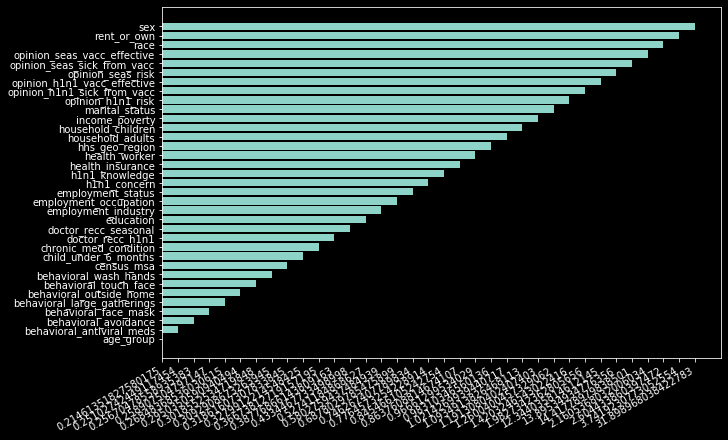

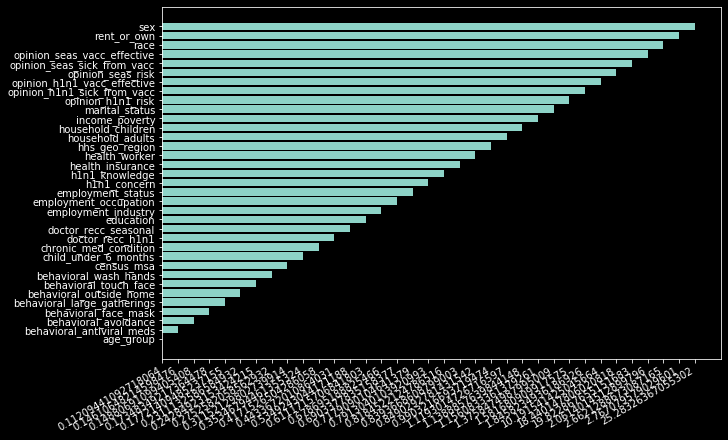

In [18]:
# Графики feature importances

for model_name, best_model_dict in models.items():
    print(model_name)
    print(best_model_dict)
    model = best_model_dict['model'][0]
    print(type(model), model)
    for feature_name, feature_importance in zip(model.feature_names_, model.feature_importances_):
        if feature_importance < 0.01:
            print( feature_name, feature_importance)

    importances_np = np.sort(np.array([model.feature_importances_, model.feature_names_]), axis=1)

    fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True);
    ax.barh(importances_np[1], importances_np[0], align='center');
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right");


In [19]:
print("submission")

submission_df = pd.DataFrame(index=test_set.index)
for i, (col, best_model_dict) in enumerate(models.items()):
    test_pool = Pool(test_set, cat_features=test_set.columns)

    predictions_df = pd.DataFrame(index=test_set.index)
    for model in best_model_dict['model']:
        predictions_df[i] = model.predict_proba(test_pool)[:, 1]
            
        
    submission_df[col] = predictions_df.mean(axis=1)

print("submission_df.shape", submission_df.shape)
print(submission_df.head())

submission
submission_df.shape (26708, 2)
               h1n1_vaccine  seasonal_vaccine
respondent_id                                
26707              0.285718          0.220008
26708              0.109557          0.047753
26709              0.431020          0.718919
26710              0.862241          0.924692
26711              0.676633          0.567157


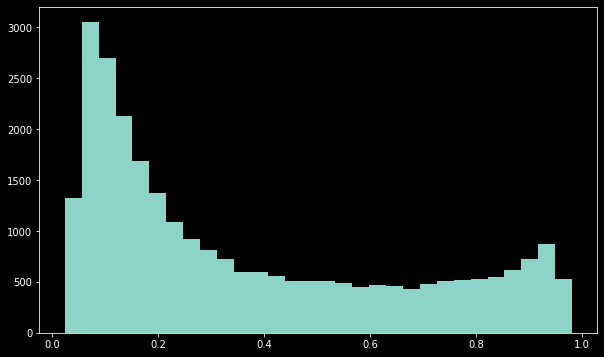

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(submission_df.h1n1_vaccine, bins=30);

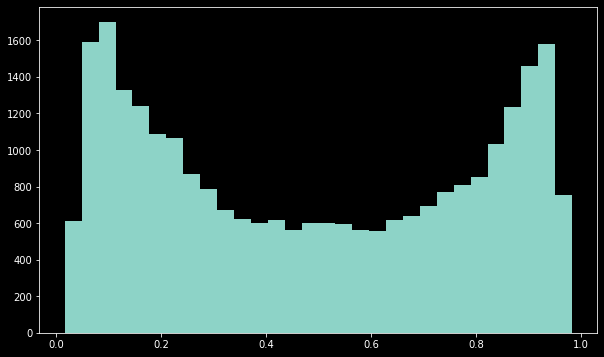

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(submission_df.seasonal_vaccine, bins=30);

In [22]:
submission_df.to_csv("./flu_submission_ycloud.csv")

In [23]:
print('*********   FINISH  ************')




*********   FINISH  ************
